# Age model interpolation function

## Background

The δ18O stratigraphy of sediment cores is a powerful tool for learning about Earth’s prehistoric climate; before modern humans were around and/or capable of recording detailed measurements for themselves.

δ18O is a stable isotope that is measured through the analysis of tiny single celled organisms called foraminifera. As foraminifera grow, they incorporate ions from the surrounding seawater into their shells, including the δ18O signature of that water. When they die, their shells fall through the water column and over time, accumulate in sedimentary layers on the seafloor.

Analysis of δ18O is insightful for studying climate because its composition in seawater varies as a direct result of changes in global temperature and ice volume. However, in order to accurately interpret δ18O values from sediment cores in the context of Earth’s history, we need to know the date in time that each sedimentary layer was deposited. Complicating this process, is that sedimentary layers are not deposited at a constant rate. Instead, sedimentation rate can vary significantly throughout time due to changes in factors such as changing ocean currents and sea level. Luckily, tools like radiocarbon analysis and alignment to global reference data can help to assign some ages to specific depths throughout a sediment core, constructing what is known as an age model. For everything in between, an interpolation function can be useful for filling in missing ages based off of the tie points that we know.

Here I develop a function that interpolates ages for a given isotope stratigraphy dataset based on an age model of tie points. The function also produces some summary statistics for depths with multiple samples. Through plotting the results, we can examine a history of Earth’s climate over the last 150,000 years, which spans the last glacial cycle. This record is conveniently plotted with time on the x axis rather than depth, made possible by this age model interpolation function.

Dataset citations:
Channell, J. E. T., Hodell, D. A., & Lehman, B. (1997). Relative geomagnetic paleointensity and δ18O at ODP Site 983 (Gardar Drift, North Atlantic) since 350 ka. Earth and Planetary Science Letters, 153(1–2), 103–118. https://doi.org/10.1016/s0012-821x(97)00164-7

Raymo, M. E., Oppo, D. W., Flower, B. P., Hodell, D. A., McManus, J. F., Venz, K. A., Kleiven, K. F., & McIntyre, K. (2004). Stability of North Atlantic water masses in face of pronounced climate variability during the Pleistocene. Paleoceanography, 19(2), 1–13. https://doi.org/10.1029/2003PA000921

In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
def age_model_interp(data_file, age_model_file):
    """
    Interpolate ages for a given isotope stratigraphy dataset based on an age model of tie points.
    Arguments:
    data_file: Name of the .txt file containing the dataset. Data file must have column order: 
    depth, d13C, d18O. Column headers cannot contain spaces.
    age_model_file: Name of the .txt file containing the age model. Age model file must have column order:
    depth, age. Column headers cannot contain spaces.
    Returns:
    datall: Dataframe containing the original dataset with interpolated ages. Column order:
    depth, age, d13C, d18O.
    datave: Dataframe containing averaged data and interpolated ages. Column order:
    depth, age, d18O_mean, d18O_std, d18O_se, d13C_mean, d13C_std, d13C_se, count.
    """
    
    # Read in the dataset and age model files as pandas dataframes.
    df = pd.read_csv(data_file, sep="\s+")
    df2 = pd.read_csv(age_model_file, sep="\s+")

    # Ensure dataframe is in ascending order by depth.
    df = df.sort_values(by=df.columns[0])

    # Create depth series that includes all depths including duplicates.
    depthall = df.iloc[:,0]

    # Create depth series that includes only unique depths.
    depth = df.iloc[:, 0].drop_duplicates()

    # Use inter1d to create a linear interpolation function based on your age model.
    f = interp1d(df2.iloc[:,0],df2.iloc[:,1], kind='linear', bounds_error=False)

    # Use the linear interpolation function on both sets of depths.
    ageave = f(depth)
    ageave = pd.DataFrame(ageave)

    ageall = f(depthall)
    ageall = pd.DataFrame(ageall)

    
    # Datave statistics and building final datave dataframe.

    # Count
    grouped_depths = df.iloc[:,0].groupby(df.iloc[:,0])
    count = grouped_depths.count()

    # d13C mean, std, & se
    grouped_d13C = df.iloc[:,1].groupby(df.iloc[:,0])
    d13C_mean = grouped_d13C.mean()
    d13C_std = grouped_d13C.std()
    d13C_se = grouped_d13C.sem()

    # d18O mean, std, & se
    grouped_d18O = df.iloc[:,2].groupby(df.iloc[:,0])
    d18O_mean = grouped_d18O.mean()
    d18O_std = grouped_d18O.std()
    d18O_se = grouped_d18O.sem()

    # Concatinate into new datave dataframe.
    datave = pd.concat([d18O_mean, d18O_std, d18O_se, d13C_mean, d13C_std, d13C_se, count],axis=1)
    datave.columns = ['d18O_mean', 'd18O_std', 'd18O_se','d13C_mean', 'd13C_std', 'd13C_se', 'count']
    datave.reset_index(inplace=True)

    # Drop NaNs from interp output for ageave.
    ageave = ageave.dropna()

    # Slice datave dataframe to same length as our new series of interpolated ages. Need to copy the dataframe, otherwise you'll get a warning further down when you try to concatinate to this slice.
    datave = datave.iloc[:len(ageave)].copy()

    # Insert interpolated age column into our df as the second column.
    datave.insert(1, 'age', ageave)

    
    # Building datall dataframe.

    # Drop NaNs from interp output for ageall.
    ageall = ageall.dropna()

    # Slice datave dataframe to same length as our new series of interpolated ages. Need to copy the dataframe, otherwise you'll get a warning further down when you try to concatinate to this slice.
    datall = df.iloc[:len(ageall)].copy()

    # Insert interpolated age column into our datall dataframe as the second column.
    datall.insert(1, 'age', ageall)
    
    return datall, datave

In [3]:
data_file = 'ODP983_iso.txt'
age_model_file = 'odp983_age_2020.txt'

datall, datave = age_model_interp(data_file,age_model_file)

In [4]:
# Set pandas to display all rows in dataframe rather than a summary slice.
pd.set_option('display.max.rows', 5000)

In [5]:
# Let's take a look at what we have in our datave dataframe.
datave

,%depth,age,d18O_mean,d18O_std,d18O_se,d13C_mean,d13C_std,d13C_se,count
0,0.15,0.009541,2.750,NaN,NaN,1.090,NaN,NaN,1
1,0.24,0.015266,2.800,NaN,NaN,0.950,NaN,NaN,1
2,0.30,0.019082,2.780,NaN,NaN,1.160,NaN,NaN,1
3,0.45,1.149037,2.790,NaN,NaN,1.080,NaN,NaN,1
4,0.66,2.060743,2.780,NaN,NaN,1.090,NaN,NaN,1
5,0.75,2.569770,2.750,NaN,NaN,0.920,NaN,NaN,1
6,0.78,2.750649,2.770,NaN,NaN,1.010,NaN,NaN,1
7,0.81,2.931529,2.580,NaN,NaN,0.980,NaN,NaN,1
8,0.84,3.112409,2.590,NaN,NaN,1.200,NaN,NaN,1
9,1.05,4.373438,2.830,NaN,NaN,1.290,NaN,NaN,1


In [6]:
# Let's take a look at what we have in our datall dataframe.
datall

,%depth,age,d13C,d18O
0,0.15,0.009541,1.09,2.75
1,0.24,0.015266,0.95,2.80
2,0.30,0.019082,1.16,2.78
3,0.45,1.149037,1.08,2.79
4,0.66,2.060743,1.09,2.78
5,0.75,2.569770,0.92,2.75
6,0.78,2.750649,1.01,2.77
7,0.81,2.931529,0.98,2.58
8,0.84,3.112409,1.20,2.59
9,1.05,4.373438,1.29,2.83


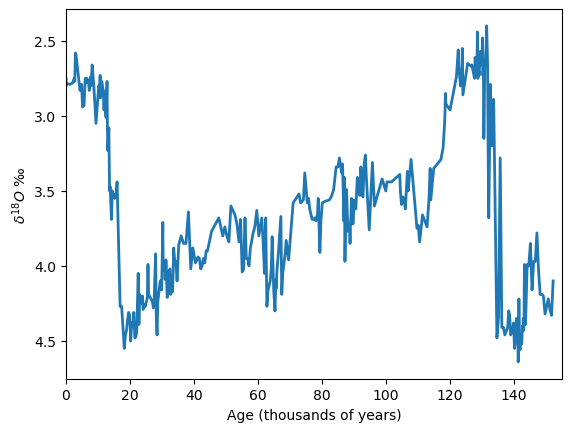

In [11]:
# Plot data on newly interpolated ages.
fig, ax = plt.subplots()
ax.plot(datave.iloc[:,1], datave.iloc[:,2], linewidth=2.0)
ax.set_xlim(0,155)
plt.gca().invert_yaxis()
plt.xlabel("Age (thousands of years)")
plt.ylabel("$\u03B4^{18}O$ \u2030")
plt.show()

### Description
Starting at present and moving back in time, we begin in the relatively warm Holocene; then descend into the Last Glacial Maximum (~20,000 years ago) when sea level was 120 m lower and much of this water was stored in gigantic polar icecaps; we gradually make our way back up to the Last Interglacial Period (~130,000 ago); and finally, back down into the penultimate glacial period.